Epoch 1/50


c:\Users\Acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0685 - val_loss: 0.0412
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0491 - val_loss: 0.0319
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0454 - val_loss: 0.0278
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0472 - val_loss: 0.0313
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0441 - val_loss: 0.0292
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0449 - val_loss: 0.0273
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0442 - val_loss: 0.0267
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0445 - val_loss: 0.0249
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0493 - val_loss: 0.0263
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0419 - val_loss: 0.0293
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0431 - val_loss: 0.0274
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0424 - val_l

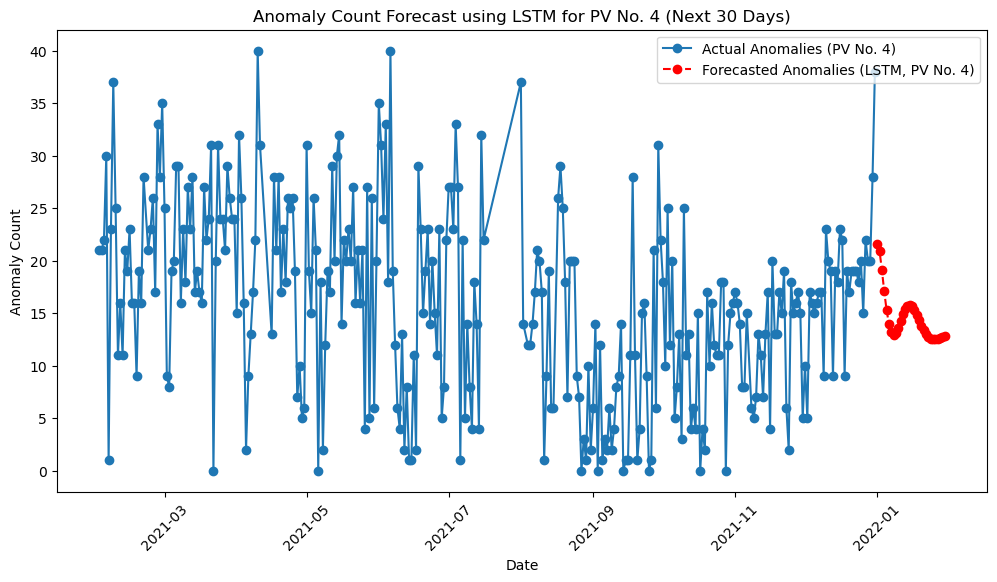

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# โหลดข้อมูล (แทนที่ไฟล์ด้วยของคุณเอง)
file_path = "forlearnpredic.csv"
df = pd.read_csv(file_path)

# แปลงคอลัมน์ Date เป็น datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# เลือกเฉพาะ PV_no. 4
df_pv4 = df[df['PV_no.'] == 4].copy()

# สรุปจำนวน anomaly ต่อวัน
df_anomaly_pv4 = df_pv4.groupby('Date')['Anomaly_Label'].sum().reset_index()

# สเกลข้อมูลให้อยู่ในช่วง 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
df_anomaly_pv4_scaled = scaler.fit_transform(df_anomaly_pv4[['Anomaly_Label']])

# ฟังก์ชันสร้างลำดับข้อมูลสำหรับ LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 100  # ใช้ข้อมูลย้อนหลัง 10 วัน
X, y = create_sequences(df_anomaly_pv4_scaled, seq_length)

# แบ่งข้อมูลเป็น train และ test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# สร้างโมเดล LSTM
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# คอมไพล์โมเดล
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# ฝึกโมเดล
model_lstm.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# เตรียมข้อมูลสำหรับพยากรณ์
forecast_steps = 30  # พยากรณ์ล่วงหน้า 30 วัน
last_sequence = df_anomaly_pv4_scaled[-seq_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)

# พยากรณ์
forecast_lstm = []
current_seq = last_sequence

for _ in range(forecast_steps):
    predicted = model_lstm.predict(current_seq, verbose=0)
    forecast_lstm.append(predicted[0, 0])
    current_seq = np.roll(current_seq, -1, axis=1)
    current_seq[0, -1, 0] = predicted[0, 0]

# แปลงค่ากลับเป็นสเกลเดิม
forecast_lstm = scaler.inverse_transform(np.array(forecast_lstm).reshape(-1, 1)).flatten()

# สร้างวันที่สำหรับพยากรณ์
future_dates_pv4 = pd.date_range(start=df_anomaly_pv4['Date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_steps)

# พล็อตผลลัพธ์
plt.figure(figsize=(12, 6))
plt.plot(df_anomaly_pv4['Date'], df_anomaly_pv4['Anomaly_Label'], label='Actual Anomalies (PV No. 4)', marker='o')
plt.plot(future_dates_pv4, forecast_lstm, label='Forecasted Anomalies (LSTM, PV No. 4)', marker='o', linestyle='dashed', color='red')
plt.xlabel('Date')
plt.ylabel('Anomaly Count')
plt.title('Anomaly Count Forecast using LSTM for PV No. 4 (Next 30 Days)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [31]:
# บันทึกโมเดลในรูปแบบ HDF5
model_lstm.save("lstm_anomaly_model.h5")

# บันทึกตัวแปลงค่า (Scaler) เพื่อใช้กับข้อมูลใหม่
import joblib
joblib.dump(scaler, "scaler.pkl")

print("โมเดลและ Scaler ถูกบันทึกเรียบร้อยแล้ว!")


โมเดลและ Scaler ถูกบันทึกเรียบร้อยแล้ว!
